In [1]:
from fastai.vision.all import *

path = untar_data(URLs.PASCAL_2007)

In [2]:
df = pd.read_csv(path / 'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [3]:
dblock = DataBlock()
dsets = dblock.datasets(df)

dsets.train[0]

(fname       009597.jpg
 labels           train
 is_valid          True
 Name: 4825, dtype: object,
 fname       009597.jpg
 labels           train
 is_valid          True
 Name: 4825, dtype: object)

In [4]:
dblock = DataBlock(
    get_x=lambda r: r['fname'],
    get_y=lambda r: r['labels']
)
dsets = dblock.datasets(df)
dsets.train[0]

('006061.jpg', 'cat bottle tvmonitor')

In [5]:
def get_x(r):
    return path / 'train' / r['fname']


def get_y(r):
    return r['labels'].split(' ')


dblock = DataBlock(
    get_x=get_x,
    get_y=get_y
)

dsets = dblock.datasets(df)
dsets.train[0]

(Path('C:/Users/liude/.fastai/data/pascal_2007/train/004191.jpg'),
 ['motorbike', 'person'])

In [6]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y
)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=375x500,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 1., 0.]))

In [7]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#1) ['train']

In [8]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    splitter=splitter,
    get_x=get_x,
    get_y=get_y
)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

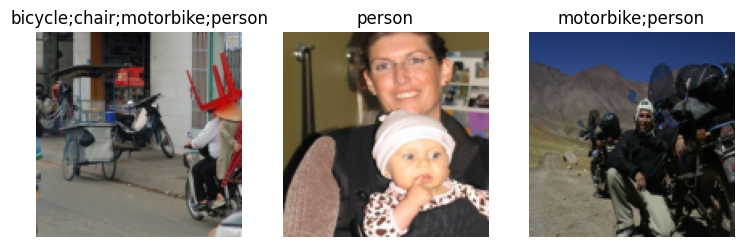

In [9]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    splitter=splitter,
    get_x=get_x,
    get_y=get_y,
    item_tfms=[RandomResizedCrop(128, min_scale=0.35)]
)

dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)

## 看看你的batch！
Knowing how to manually get a mini-batch and pass it into a
model, and look at the activations and loss, is really important for
debugging your model. It is also very helpful for learning, so that
you can see exactly what is going on.

In [10]:
learn = vision_learner(dls, resnet18, )
x, y = dls.train.one_batch()
learn._set_device('cuda')

In [15]:
activs = learn.model(x)

'cuda'

In [16]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()



In [17]:
# 等价于pytorch的BCEWithLogitsLoss
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, Tensor(y))
loss

TensorImage(1.3675, device='cuda:0', grad_fn=<AliasBackward0>)

In [18]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid:
        inp = inp.sigmoid()
    return ((inp>thresh) == targ.bool()).float().mean()



In [19]:
learn = vision_learner(
    dls,
    resnet50,
    metrics=partial(accuracy_multi, thresh=0.2)
)
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\liude/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 38.5MB/s]


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.949506,0.716612,0.213108,00:22
1,0.824868,0.553023,0.280060,00:20
2,0.602370,0.210026,0.795538,00:20
3,0.354806,0.119733,0.941135,00:20


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.125557,0.103570,0.953088,00:21
1,0.113551,0.098802,0.959761,00:21
2,0.098112,0.095204,0.957052,00:21


In [20]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.09520405530929565,0.9383665323257446]

In [21]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.09520405530929565,0.9445218443870544]

In [22]:
preds, targs = learn.get_preds()
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9597)

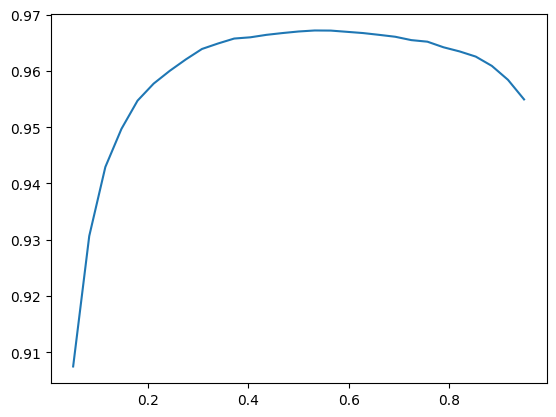

In [23]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

# 回归

In [26]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('C:/Users/liude/.fastai/data/biwi_head_pose/01'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/01.obj'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/02'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/02.obj'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/03'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/03.obj'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/04'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/04.obj'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/05'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/05.obj')...]

In [27]:
(path/'01').ls()

(#1000) [Path('C:/Users/liude/.fastai/data/biwi_head_pose/01/depth.cal'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/01/frame_00004_pose.txt'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/01/frame_00004_rgb.jpg'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/01/frame_00005_pose.txt'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/01/frame_00005_rgb.jpg'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/01/frame_00006_pose.txt'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/01/frame_00006_rgb.jpg'),Path('C:/Users/liude/.fastai/data/biwi_head_pose/01/frame_00007_pose.txt')...]

In [28]:
img_files = get_image_files(path)
def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')

img2pose(img_files[0])

Path('C:/Users/liude/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt')

In [29]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

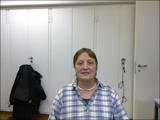

In [30]:
im.to_thumb(160)

In [31]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [32]:
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

get_ctr(img_files[0])

tensor([350.4915, 262.9643])

In [33]:
biwi = DataBlock(
    blocks=[ImageBlock, PointBlock],
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
                Normalize.from_stats(*imagenet_stats)]
)


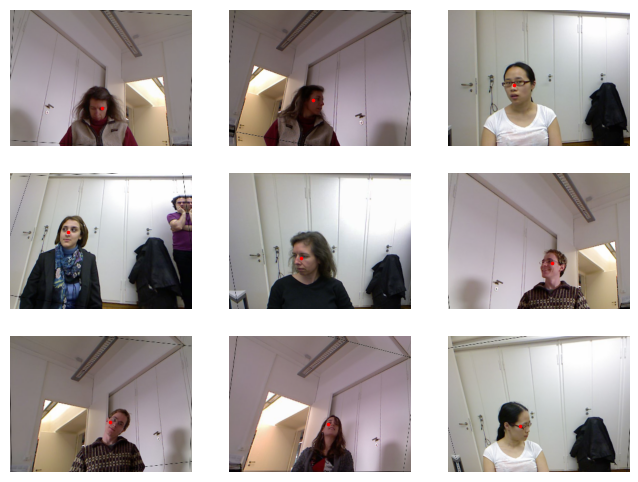

In [36]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [37]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [38]:
learn = vision_learner(
    dls,
    resnet18,
    y_range=(-1,1)
)


In [39]:
def sigmoid_range(x, lo, hi):
    return torch.sigmoid(x)* (hi-lo) + lo + lo

In [40]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0010000000474974513)

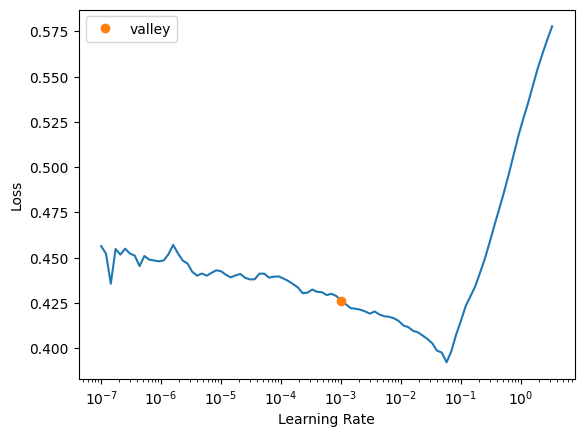

In [41]:
learn.lr_find()

In [42]:
lr = 0.0010000000474974513
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.263233,0.089105,01:37
1,0.036563,0.003395,01:36
2,0.011125,0.001782,01:35
3,0.007753,0.000767,01:34
4,0.006835,0.000749,01:37


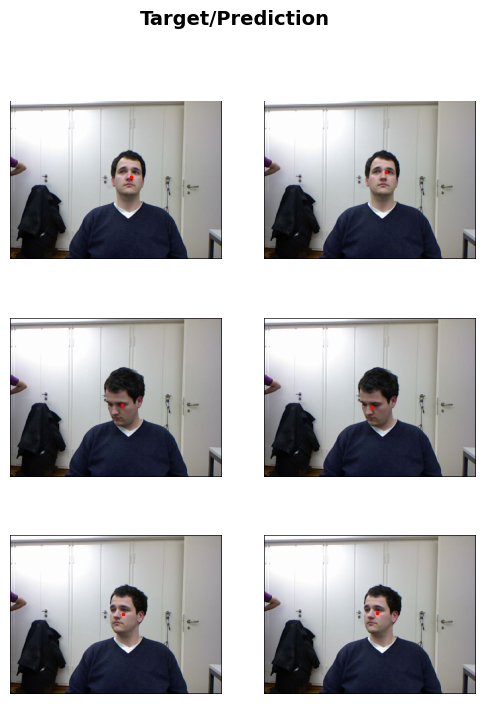

In [43]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))